# Programming Exercise 5: Regularized Linear Regression and Bias v.s. Variance

## Introduction
In this exercise, you will implement regularized linear regression and use it to study models with different bias-variance properties.

## 1. Regularized Linear Regression
In the first half of the exercise, you will implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir. In the next half, you will go through some diagnostics of debugging learning algorithms and examine the effects of bias v.s. variance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import minimize
from scipy.io import loadmat  # to load .mat file

%matplotlib inline

### 1.1. Visualizing the dataset
We will begin by visualizing the dataset containing historical records on the change in the water level, $x$, and the amount of water flowing out of the dam, $y$.

This dataset is divided into three parts:
- A **training** set that your model will learn on: `X`, `y`
- A **cross validation** set for determining the regularization parameter: `Xval`, `yval`
- A **test** set for evaluating performance. These are "unseen" examples which your model did not see during training: `Xtest`, `ytest`

In [2]:
# Loading and Visualizing Data
data = loadmat('data/ex5/ex5data1.mat')  # data is a 'dict' object
# Get X and y from dict data
X = data['X']         # X.shape = (12, 1)
y = data['y']         # y.shape = (12, 1)
Xval = data['Xval']   # Xval.shape = (21, 1)
yval = data['yval']   # yval.shape = (21, 1)
Xtest = data['Xtest'] # Xtest.shape = (21, 1)
ytest = data['ytest'] # ytest.shape = (21, 1)

m = X.shape[0] # the number of training examples

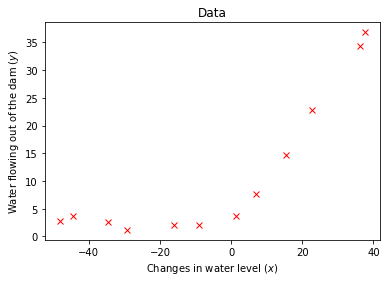

In [3]:
# Plot training data
plt.plot(X, y, 'rx')
plt.xlabel(r"Changes in water level ($x$)")
plt.ylabel(r"Water flowing out of the dam ($y$)")
plt.title("Data")
plt.show()

### 1.2. Regularized linear regression cost function
Recall that regularized linear regression has the following cost function:
$$ J(\theta) = \frac{1}{2m}(\sum_{i=1}^m(h_{\theta}(x^{(i)})-y^{(i)})^2) + \frac{\lambda}{2m}(\sum_{j=1}^n \theta_j^2) $$
where $\lambda$ is a regularization parameter which controls the degree of regularization (thus, help preventing overfitting). The regularization term puts a penalty on the overal cost $J$. As the magnitudes of the model parameters $\theta_j$ increase, the penalty increases as well. Note that you should not regularize the $\theta_0$ term.

You should now complete the code in the function `linear_reg_cost_function`. Your task is to write a function to calculate the regularized linear regression cost function. If possible, try to vectorize your code and avoid writing loops. When you are finished, the next part of code will run your cost function using `theta` initialized at `[1; 1]`. You should expect to see an output of 303.993.

### 1.3. Regularized linear regression gradient
Correspondingly, the partial derivative of regularized linear regression’s cost for $\theta_j$ is defined as
$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)})x_j^{(i)} \qquad \text{for } j = 0 $$
$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left(\frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)})x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j \qquad \text{for } j \geq 1 $$

In `linear_reg_cost_function`, add code to calculate the gradient, returning it in the variable `grad`. When you are finished, the next part will run your gradient function uisng `theta` initialized at `[[1], [1]]`. You should expect to see a gradient of `[[-15.30], [598.250]]`.

In [4]:
def linear_reg_cost_function(theta, X, y, lambd):
    """
    Compute cost and gradient for regularized linear regression with
    multiple variables
    """
    
    m = X.shape[0] # the number of training examples
    
    theta = theta.reshape((theta.shape[0], 1))
    
    J = (X @ theta - y).T @ (X @ theta - y) / (2 * m)
    + theta[1:].T @ theta[1:] * lambd / (2 * m)
    
    J = np.squeeze(J)
    
    grad = ((X @ theta - y).T @ X).T / m + lambd / m * theta
    grad[0] = (X @ theta - y).T @ X[:, 0] / m
    
    return J, grad.ravel()

In [5]:
theta = np.array([[1], [1]])

J, grad = linear_reg_cost_function(theta, np.hstack((np.ones((m, 1)), X)), \
                                   y, lambd=1)
print("Cost at theta = [[1], [1]]: {0} \n (this value should be ".format(J)
      + "about 303.993192")
print("Gradient at theta = [[1], [1]]: [[{0}], [{1}]".format(grad[0], grad[1]) 
      + "\n (this value should be about [[-15.303016], [598.250744]])")

Cost at theta = [[1], [1]]: 303.9515255535976 
 (this value should be about 303.993192
Gradient at theta = [[1], [1]]: [[-15.303015674201184], [598.2507441727037]
 (this value should be about [[-15.303016], [598.250744]])


### 1.4. Fitting linear regression
Once your cost function and gradient are working correctly, the next part will run the code in `train_linear_reg` to compute the optimal values of $\theta$.

In this part, we set regularization parameter $\lambda$ to zero. Because our current implementation of linear regression is trying to fit a 2-dimensional $\theta$, regularization will not be incredibly helpful for a $\theta$ of such low dimension. In the later parts of the exercise, you will be using polynomial regression with regularization.

Finally, the script should also plot the best fit line. The best fit line tells us that the model is not a good fit to the data because the data has a non-linear pattern. While visualizing the best fit as shown is one possible way to debug your learning algorithm, it is not always easy to visualize the data and model. In the next section, you will implement a function to generate learning curves that can help you debug your learning algorithm even if it is not easy to visualize the data.

In [6]:
def train_linear_reg(X, y, lambd):
    """
    Train linear regression given a dataset (X, y) and a regularization
    parameter lambda
    """
    # Initialize the theta
    initial_theta = np.zeros((X.shape[1], 1))
    # Use mimimize to optimize theta
    optimize_result = minimize(fun=linear_reg_cost_function, \
                               x0=initial_theta.ravel(), \
                               args=(X, y, lambd), method='TNC', \
                               jac=True, options={'maxiter':200})
    
    return optimize_result.x.reshape((X.shape[1], 1))

In [7]:
# Train a linear regression with lambd = 0
lambd = 0
theta = train_linear_reg(np.hstack((np.ones((m, 1)), X)), y, lambd)
print(theta)

[[ 13.08790351]
 [  0.36777923]]


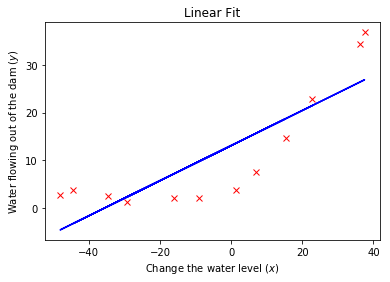

In [8]:
# Plot fit over the data
plt.plot(X, y, 'rx')
plt.xlabel(r'Change the water level ($x$)')
plt.ylabel(r'Water flowing out of the dam ($y$)')
plt.plot(X, np.hstack((np.ones((m, 1)), X)) @ theta, 'b-')
plt.title("Linear Fit")
plt.show()

## 2. Bias-variance
A important concept in machine learning is the bias-variance tradeoff. Models with high bias are not complex enough for the data and tend to underfit, while models with high variance overfit to the training data.

In this part of the exercise, you will plot training and test errors on a learning curve to diagnose bias-variance problems.

### 2.1. Learning curves
You will now implement code to generate the learning curves that will be useful in debugging learning algorithms. Recall that a learning curve plots training and cross validation error as a function of training set size. Your job is to fill in `learning_curve` function so that it returns a vector of errors for the training set and cross validation set.

To plot the learning curve, we need a training and cross validation set error for different *traing* set sizes. To obtain different training set sizes, you should use different subsets of the original training set `X`. Specifically, for a training set size of `i`, you should use the first $i$ examples (i.e., `X[0:i, :]` and `y[0:i]`).

You can use `train_linear_reg` funciton to find the $\theta$ parameters. Note that the `lambd` is passes as a parameter to the `learning_curve` function. After learning the $\theta$ parameters, yo ushould compute the **error** on the training and cross validation sets. Recall that the training error for a dataset is defined as
$$ J_{\text{train}}(\theta) = \frac{1}{2m} \left[\sum_{i=1}^m (h_{\theta}(x^{(i)}) - y^{(i)})^2\right] $$

In particular, note that the training error does not include the regularization term. One way to compute the training error is to use your existing cost function and set $\lambda$ to 0 only when using it to compute the training error and cross validation error. When you are computing the training set error, make sure you compute it on the training subset (i.e., `X[0:n,:]` and `y[0:n]` (instead of the entire training set). However, for the cross validation error, you should compute it over the entire cross validation set. You should store the computed errors in the vectors `error_train` and `error_val`.

In [9]:
def learning_curve(X, y, Xval, yval, lambd):
    """
    Generate the trian and cross validation set errors needed to plot a
    learning curve.
    """
    
    m = X.shape[0] # the number of training examples
    
    # Training set error with different training set sizes
    error_train = np.zeros(m)
    # Cross validation set error with different training set sizes
    error_val = np.zeros(m)
    
    for i in range(m):
        # Use the first i examples to train theta
        theta = train_linear_reg(X[0:i+1], y[0:i+1], lambd)
        # compute the error on training set and cross validation set
        error_train[i], _ = linear_reg_cost_function(theta, X[0:i+1], \
                                                  y[0:i+1], lambd=0)
        error_val[i], _ = linear_reg_cost_function(theta, Xval, \
                                                yval, lambd=0)
        
    return error_train, error_val

# Training Examples	Train Error		Cross Validation Error
         1          1.0176953929799205e-18	 205.1210957127572  
         2          3.4671308818173964e-09	 110.30264077542827 
         3           3.2865950455012762 	 45.01023141808298  
         4           2.842677689399861  	 48.368910618052006 
         5           13.154048809114922 	 35.86516471900797  
         6           19.44396251249548  	 33.829961408560834 
         7           20.098521655088884 	  31.9709857752606  
         8           18.172858695200027 	 30.862446352979585 
         9           22.609405424954723 	 31.135997990661583 
         10          23.261461592611813 	 28.93620746815605  
         11          24.31724958804416  	 29.551431622434496 
         12          22.373906495108912 	 29.433818132449204 


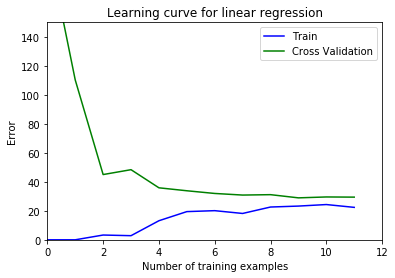

In [10]:
lambd = 0 # set the regularization parameter to 0
# Get the error on training set and cross validation set with different
# training set sizes
error_train, error_val = learning_curve(np.hstack((np.ones((m, 1)), X)), \
                                       y, np.hstack((np.ones((Xval.shape[0], 1)), Xval)), \
                                       yval, lambd)

# Print the errors
print("# Training Examples\tTrain Error\t\tCross Validation Error")
for i in range(m):
    print("{:^20}{:^20}\t{:^20}".format(i+1, error_train[i], error_val[i]))

# Plot the learning curve
plt.plot(np.arange(0, m), error_train, 'b-', label="Train")
plt.plot(np.arange(0, m), error_val, 'g-', label="Cross Validation")
plt.legend()
plt.title("Learning curve for linear regression")
plt.xlabel("Number of training examples")
plt.ylabel("Error")
plt.axis([0, 12, 0, 150])
plt.show()

In the above figure, we can observe that *both* the train error and cross validation error are high when the nubmer of training examples is increased. this reflects a **high bias** problem in the model - the linear regression model is to simple and is unable to fit our dataset well. In the next section, you will implement polynomial regression to fit a better model for this dataset.

## 3. Plolynomial regression
The problem with our linear model was that it was too simple for the data and resulted in underfitting (high bias). In this part of the exercise, you will address this problem by adding more features.

For use polynomial regression, our hypothesis has the form:
$$ h_{\theta}(x) = \theta_0 + \theta_1 * (\text{waterLevel}) + \theta_2 * (\text{waterLevel})^2 + \cdots + \theta_p * (\text{waterLevel})^p \\ = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_p x_p $$

Note that by defining $x_1 = (\text{waterLevel})$, $x_2 = (\text{waterLevel})^2$, \ldots, $x_p = (\text{waterLevel})^p$, we obtain a linear regression model where the features are the various powers of the original value (waterLevel).

Now, you will add more features using the higher powers of the existing feature $x$ in the dataset. Your task in this part is to complete the code in `poly_features` function so that the function maps the original training set `X` of size $m \times 1$ into its higher powers. Specifically, when a training set `X` of size $m \times 1$ is passed into the function, the function should return a $m \times p$ matrix `X_poly`, where column 1 holds the original values of `X`, column 2 holds the values of `X.^2`, column 3 holds the values of `X.^3`, and so on. Note that you don’t have to account for the zero-th power in this function.

Now you have a function that will map features to a higher dimension, and the next part of the exercise will apply it to the training set, the test set, and the cross validation set (which you haven't used yet).

In [11]:
def poly_features(X, p):
    """
    Map X (1D vector) into the p-th power
    """
    
    X_poly = np.zeros((X.shape[0], p))
    for i in range(p):
        X_poly[:, [i]] = np.power(X, i+1)
        
    return X_poly

In [12]:
def feature_normalize(X):
    """
    Normalize the features in X
    """

    mu = np.mean(X, axis=0, keepdims=True)
    # Set `ddof=1` to get same std result in MATLAB
    # https://stackoverflow.com/questions/27600207/why-does-numpy-std-give-a-different-result-to-matlab-std
    sigma = np.std(X, axis=0, ddof=1, keepdims=True)
    X_norm = (X - mu) / sigma
    
    return X_norm, mu, sigma

In [13]:
# Feature mapping for Polynomial Regression
p = 8 # the power of polynomial features

# Map X onto Polynomial Features and Normalize
X_poly = poly_features(X, p)
X_poly, mu, sigma = feature_normalize(X_poly)
# Add ones to X_poly
X_poly = np.hstack((np.ones((X_poly.shape[0], 1)), X_poly))

# Map X_poly_val and normalize (using mu and sigma)
X_poly_val = poly_features(Xval, p)
X_poly_val = (X_poly_val - mu) / sigma
# Add ones to X_poly_val
X_poly_val = np.hstack((np.ones((X_poly_val.shape[0], 1)), X_poly_val))

# Map X_poly_test and normalize (using mu and s)
X_poly_test = poly_features(Xtest, p)
X_poly_test = (X_poly_test - mu) / sigma
# Add ones to X_poly_test
X_poly_test = np.hstack((np.ones((X_poly_test.shape[0], 1)), X_poly_test))

print("Normalized Training Example 1:")
print(str(X_poly[0, :]))

Normalized Training Example 1:
[ 1.         -0.36214078 -0.75508669  0.18222588 -0.70618991  0.30661792
 -0.59087767  0.3445158  -0.50848117]


### 3.1. Learning Polynomial Regression
After you have completed `poly_features` function, the script will proceed to train polynomial regression using your linear regression cost function.

Keep in mind that even though we have polynomial terms in our feature vector, we are still solving a linear regression optimization problem. The polynomial terms have simply turned into features that we can use for linear regression. We are using the same cost function and gradient that you wrote for the earlier part of this exercise.

For this part of the exercise, you will be using a polynomial of degree 8. It turns out that if we run the training directly on the projected data, will not work well as the features would be badly scaled (e.g., an example with $x = 40$ will now have a feature $x_8 = 40^8 = 6.5 \times 10^{12}$). Therefore, you will need to use feature normalization.

Before learning the parameters $\theta$ for the polynomial regression, the script will first call `feature_normalize` and normalize the features of the training set, storing the `mu`, `sigma` parameters separately. We have already implemented this function for you and it is the same function from the first exercise.

After learning the parameters $\theta$, you should see two plots generated for polynomial regression with $\lambda = 0$.

In [14]:
def poly_reg_plot_fit_and_learning_curve(X_poly, y, lambd):
    """
    Polynomial Regression, plot the fit and the learning curve.
    """

    # Train the theta
    theta = train_linear_reg(X_poly, y, lambd)

    # Plot the training data and fit
    plt.plot(X, y, 'rx')

    # Plot a learned polynomial regression fit over an existing figure.
    # We plot a range slightly bigger than the min and max values to get
    # an idea of how the fit will vary outside the range of the data points
    figure_x = np.linspace(np.min(X)-15, np.max(X)+25, 2000)[np.newaxis].T

    # Map the features
    figure_X_poly = poly_features(figure_x, p)
    figure_X_poly = (figure_X_poly - mu) /sigma
    # Add ones
    figure_X_poly = np.hstack((np.ones((figure_X_poly.shape[0], 1)), \
                               figure_X_poly))

    # Plot the Polynomial Regression fit figure
    plt.plot(figure_x, figure_X_poly @ theta, 'b--')
    plt.title(r"Polynomial Regression Fit ($\lambda$ = {})".format(lambd))
    plt.xlabel(r'Change the water level ($x$)')
    plt.ylabel(r'Water flowing out of the dam ($y$)')
    plt.show()

    # Get the errors of different training set sizes
    error_train, error_val = learning_curve(X_poly, y, X_poly_val, yval, lambd)
    # Plot the learning curve
    plt.plot(np.arange(0, m), error_train, 'b-', label="Train")
    plt.plot(np.arange(0, m), error_val, 'g-', label="Cross Validation")
    plt.legend()
    plt.title("Learning curve for linear regression ($\lambda$ = {})".format(lambd))
    plt.xlabel("Number of training examples")
    plt.ylabel("Error")
    plt.axis([0, 12, 0, 150])
    plt.show()
    
    return error_train, error_val

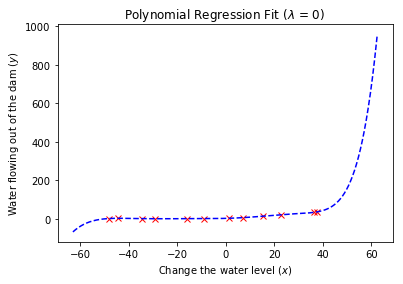

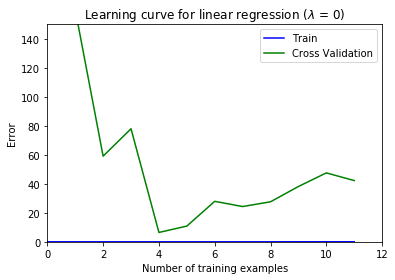

# Training Examples	Train Error		Cross Validation Error
         1          3.859502067817641e-18	 160.72189969292504 
         2          2.189359242224816e-16	  160.121510492453  
         3          7.494109719834655e-16	 59.071641173396905 
         4          1.1980022026240723e-14	 77.99773843545455  
         5          1.490675794194503e-14	 6.448324818101524  
         6          1.4429401941959437e-08	 10.83381578259784  
         7          1.4621344341937597e-08	 27.917035098253013 
         8          6.6200753984439955e-06	 24.32113622697692  
         9          5.754243408290311e-05	 27.602334327495676 
         10         0.028170074915850517	 38.15780552123627  
         11         0.031292736129684154	 47.53763733252964  
         12         0.03014347330693996 	 42.24041858409674  


In [15]:
# Polynomial Regression with lambd = 0
# See https://www.coursera.org/learn/machine-learning/discussions/weeks/6/threads/P3Cp9j_ZEeaDRA5SxbW7qQ
# if you have questions about the Polynomial Regression fit figure
error_train, error_val = poly_reg_plot_fit_and_learning_curve(X_poly, y, lambd=0)

# Print the errors
print("# Training Examples\tTrain Error\t\tCross Validation Error")
for i in range(m):
    print("{:^20}{:^20}\t{:^20}".format(i+1, error_train[i], error_val[i]))

From the above figure, you should see that the polynomial fit is able to follow the datapoints very well - thus, obtaining a low training error. However, the polynomial fit is very complex and even drops off at the extremes. This is an indicator that the polynomial regression model is overfitting the training data and will not generalize well.

To better understand the problems with the unregularized $(\lambda = 0)$ model, you can see that the learning curve shows the same effect where the low training error is low, but the cross validation error is high. There is a gap between the training and cross validation errors, indicating a high variance problem.

One way to combat the overfitting (high-variance) problem is to add regularization to the model. In the next section, you will get to try different $\lambda$ parameters to see how regularization can lead to a better model.

### 3.2. Optional (ungraded) exercise: Adjusting the reg- ularization parameter
In this section, you will get to observe how the regularization parameter affects the bias-variance of regularized polynomial regression. You should now modify the the **lambd** parameter in the script and try $\lambda$ = 1, 100. For each of these values, the script should generate a polynomial fit to the data and also a learning curve.

For $\lambda$ = 1, you should see a polynomial fit that follows the data trend well and a learning curve showing that both the cross validation and training error converge to a relatively low value. This shows the $\lambda$ = 1 regularized polynomial regression model does not have the high- bias or high-variance problems. In effect, it achieves a good trade-off between bias and variance.

For $\lambda$ = 100, you should see a polynomial fit that does not follow the data well. In this case, there is too much regularization and the model is unable to fit the training data.

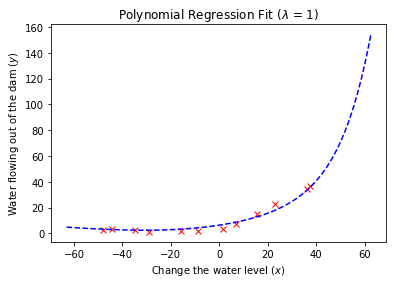

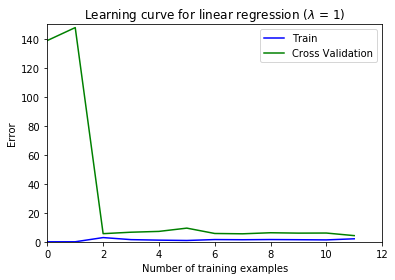

In [16]:
# Polynomial Regression with lambd = 1
_, _ = poly_reg_plot_fit_and_learning_curve(X_poly, y, lambd=1)

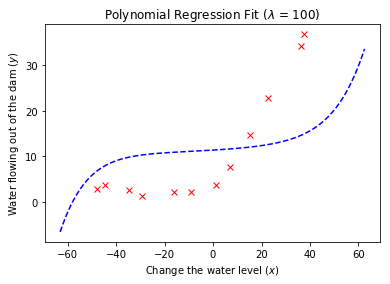

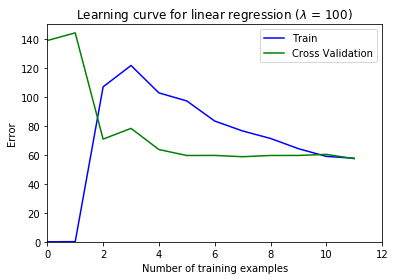

In [17]:
# Polynomial Regression with lambd = 100
_, _ = poly_reg_plot_fit_and_learning_curve(X_poly, y, lambd=100)

### 3.3. Selecting $\lambda$ using a cross validation set
From the previous parts of the exercise, you observed that the value of $\lambda$ can significantly affect the results of regularized polynomial regression on the training and cross validation set. In particular, a model without regularization ($lambda$ = 0) fits the training set well, but does not generalize. Conversely, a model with too much regularization ($\lambda$ = 100) does not fit the training set and testing set well. A good choice of $\lambda$ (e.g., $\lambda$ = 1) can provide a good fit to the data.

In this section, you will implement an automated method to select the $\lambda$ parameter. Concretely, you will use a cross validation set to evaluate how good each $\lambda$ value is. After selecting the best $\lambda$ value using the cross validation set, we can then evaluate the model on the test set to estimate how well the model will perform on actual unseen data.

Your task is to complete the code in `validation_curve`. Specifically,
you should use the `train_linear_reg` function to train the model using different values of λ and compute the training error and cross validation error.

You should try $\lambda$ in the following range: {0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10}.

In [18]:
def validation_curve(X, y, Xval, yval):
    """
    Generate the train and validation errors needed to plot a validation
    curve that we can use to select lambda
    """
    
    # A vector contains different lambdas
    lambd_vec = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])
    
    m_train = X.shape[0]  # the number of training examples
    m_val = Xval.shape[0] # the number of validation examples
    
    error_train = np.zeros(lambd_vec.shape[0])
    error_val = np.zeros(lambd_vec.shape[0])
    
    for i in range(lambd_vec.shape[0]):
        theta = train_linear_reg(X, y, lambd_vec[i])
        error_train[i] = (X@theta-y).T @ (X@theta-y) / (2*m_train)
        error_val[i] = (Xval@theta-yval).T @ (Xval@theta-yval) / (2*m_val)
        
    return lambd_vec, error_train, error_val

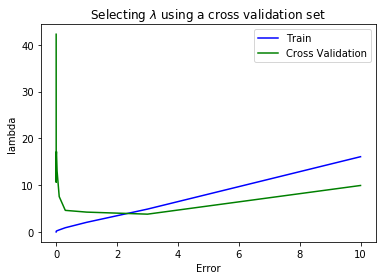

lambda		Train Error		Cross Validation Error
   1       0.03014347330693996   	 42.24041858409674  
   2       0.11288774064417333   	 10.624339762124302 
   3       0.17073585146470024   	 16.47248489244538  
   4       0.22047306295914226   	 17.170964845680313 
   5       0.28230668920009844   	 13.03016602834545  
   6       0.4578872095319837    	 7.569037501248475  
   7       0.9234681792067881    	 4.6317780047620465 
   8        2.07701882568763     	 4.259424902584349  
   9        4.900858798269163    	 3.8230509989348724 
   10      16.091682596859414    	   9.945365964592   


In [19]:
lambd_vec, error_train, error_val = validation_curve(X_poly, y, \
                                                     X_poly_val, yval)
plt.plot(lambd_vec, error_train, 'b-', label="Train")
plt.plot(lambd_vec, error_val, 'g-', label="Cross Validation")
plt.legend()
plt.title(r"Selecting $\lambda$ using a cross validation set")
plt.xlabel("Error")
plt.ylabel("lambda")
plt.show()

# Print the errors
print("lambda\t\tTrain Error\t\tCross Validation Error")
for i in range(lambd_vec.shape[0]):
    print("{:^8}{:^25}\t{:^20}".format(i+1, error_train[i], error_val[i]))

After you have completed the code, the code will run your function can plot a cross validation curve of error v.s. $\lambda$ that allows you select which $\lambda$ parameter to use. In this figure, we can see that the best value of $\lambda$ is around 3. Due to randomness in the training and validation splits of the dataset, the cross validation error can sometimes be lower than the training error.

### 3.4. Optional (ungraded) exercise: Computing test set error
In the previous part of the exercise, you implemented code to compute the cross validation error for various values of the regularization parameter $\lambda$. However, to get a better indication of the model’s performance in the real world, it is important to evaluate the “final” model on a test set that was not used in any part of training (that is, it was neither used to select the $\lambda$ parameters, nor to learn the model parameters $\theta$).

For this optional (ungraded) exercise, you should compute the test error using the best value of $\lambda$ you found. In our cross validation, we obtained a test error of 3.8599 for $\lambda$ = 3.

In [20]:
lambd = 3
theta = train_linear_reg(X_poly, y, lambd)
error_test = (X_poly_test@theta-ytest).T @ (X_poly_test@theta-ytest) \
                / (2 * X_poly_test.shape[0])
error_test = np.squeeze(error_test)
print("Error of the test set: {}".format(error_test))

Error of the test set: 3.859433956994647


### 3.5. Optional (ungraded) exercise: Plotting learning curves with randomly selected examples
In practice, especially for small training sets, when you plot learning curves to debug your algorithms, it is often helpful to average across multiple sets of randomly selected examples to determine the training error and cross validation error.

Concretely, to determine the training error and cross validation error for $i$ examples, you should first randomly select $i$ examples from the training set and $i$ examples from the cross validation set. You will then learn the parameters $\theta$ using the randomly chosen training set and evaluate the parameters $\theta$ on the randomly chosen training set and cross validation set. The above steps should then be repeated multiple times (say 50) and the averaged error should be used to determine the training error and cross validation error for $i$ examples.

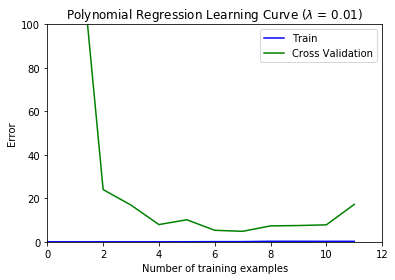

In [21]:
lambd = 0.01 # set the regularization parameter to 0.01
# Get the error on training set and cross validation set with different
# training set sizes

m = X_poly.shape[0] # the number of training examples
    
# Training set error with different training set sizes
error_train = np.zeros(m)
# Cross validation set error with different training set sizes
error_val = np.zeros(m)

for i in range(1, m+1):
    # Use random i examples to train theta
    random_i_indices = np.random.permutation(np.arange(i))[:i]
    theta = train_linear_reg(X_poly[random_i_indices], y[random_i_indices], lambd)
    # compute the error on training set and cross validation set
    error_train[i-1], _ = linear_reg_cost_function(theta, X_poly[random_i_indices], \
                                                 y[random_i_indices], lambd)
    error_val[i-1], _ = linear_reg_cost_function(theta, X_poly_val, yval, lambd)

# Plot the learning curve
plt.plot(np.arange(m), error_train, 'b-', label="Train")
plt.plot(np.arange(m), error_val, 'g-', label="Cross Validation")
plt.legend()
plt.title(r"Polynomial Regression Learning Curve ($\lambda$ = 0.01)")
plt.xlabel("Number of training examples")
plt.ylabel("Error")
plt.axis([0, 12, 0, 100])
plt.show()